<span style="color:green">

## Time-Series Analysis: Stock Portfolio Strategy Development and Evaluation

</span>

<span style="color:darkblue">

**Importing the datasets and necessary libraries**

</span>

In [18]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

stocks = pd.read_feather('crsp_monthly_stocks2.feather')
cstat  = pd.read_feather('compustat_annual.feather')
financials = pd.read_csv('rwwwph5pgksjjttg.csv')

In this project, we extensively utilize the Compustat dataset. Compustat is a critical resource for financial analysts and researchers, offering in-depth historical financial data on publicly traded companies.

The compustat dataset includes essential information for each stock, such as:

- **DATADATE**: The date of the reported financial data.
- **FYEAR**: The fiscal year corresponding to the data.
- **LPERMNO**: A unique identifier for each security.
- **AT**: Total assets.
- **CEQ**: Shareholder's equity.
- **CHE**: Cash and cash equivalents.
- **LT**: Total liabilities.
- **PSTK**: Preferred stock.
- **SEQ**: Shareholder's equity (alternative measure).
- **DVT**: Dividends total.
- **IB**: Income before extraordinary items.
- **SALE**: Total sales/revenue.
- **CAPX**: Capital expenditures.

This dataset allows us to perform a deep dive into the financial health and performance of various companies over time. We will be using all these financial metrics along with the metrics on profitability, accruals, solvency, Return on Assets and Value to filter our top 100 stocks every month. 

Download link: [Wharton Research Data Services (WRDS)](https://wrds-www.wharton.upenn.edu/).


In [24]:
cstat.head(2)

,DATADATE,FYEAR,LPERMNO,AT,CEQ,CHE,LT,PSTK,SEQ,DVT,IB,SALE,CAPX
0,1970-12-31,1970.0,25881.0,33.45,10.544,1.660,22.906,0.0,10.544,0.0,1.878,45.335,2.767
1,1971-12-31,1971.0,25881.0,29.33,8.381,2.557,20.948,0.0,8.382,0.0,0.138,47.033,1.771


<span style ="color:darkblue">

**Get the Market returns data** 

</span>

First, let's dive into getting the market reference returns to gauge our stock portfolio's market performance. Here we use the Fama-French 3-factor dataset to extract the market returns. 
$$ 
R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,M}(R_{M,t} - R_{f,t}) + \beta_{i,SMB}SMB_t + \beta_{i,HML}HML_t + \epsilon_{i,t}
$$
Mainly we'll be using the 'Mkt' return rate as a reference return to compare against our portfolio's performance  and 'rf' for return over risk-free rate. 

1. **Date Conversion and Indexing**: We first convert the 'Date' column to a datetime format, adjusting dates to each month's end that will help us with merging. Setting these dates as the DataFrame index organizes our data chronologically.

2. **Calculating Market Return (`MKT`)**: The total market return is calculated by summing the Market Return over the Risk-Free Rate (`Mkt-RF`) with the Risk-Free Rate (`RF`). This step gives us a fuller picture of the market's overall performance.

3. **Extracting Relevant Periods**: We focus on data from January 2000 to June 2023, aligning our analysis with the strategic timeline of our investment approach.

4. **Segmenting Returns**: For this timeframe, we extract and convert into decimals the Market Returns (`MKT`), Risk-Free Returns (`RF`), and Market Excess Returns over Risk-Free Rate (`Mkt-RF`).


In [20]:
ff = pd.read_csv('FFdata.csv')
ff['DATE'] = pd.to_datetime(ff['Date'].astype(str), format='%Y%m') + MonthEnd(0)
ff.set_index(['DATE'], inplace=True)
ff['MKT'] = ff['Mkt-RF'] + ff['RF']
ref_returns = (ff.loc['2000-01-01':'2023-06-30']['MKT']/100)
rf_returns = (ff.loc['2000-01-01':'2023-06-30']['RF']/100)
mkt_rf_returns = (ff.loc['2000-01-01':'2023-06-30']['Mkt-RF']/100)

In [25]:
ff.head(2)

,Date,Mkt-RF,SMB,HML,RF,MKT
DATE,,,,,,
1926-07-31,192607,2.96,-2.56,-2.43,0.22,3.18
1926-08-31,192608,2.64,-1.17,3.82,0.25,2.89


<span style = "color:darkblue">

**Clean CRSP dataset**

</span>

- Adjust to end of each month dates for consistency across all datasets
- Ensure all stock prices are positive
- Calculate each stock's market value as the product of shares outstanding and closing price.
- Remove unnecessary columns (`SHRCD`, `EXCHCD`, `SICCD`) to streamline the dataset.
- Set a multi-level index (`PERMNO`, `DATE`) so we dont fill forward one stock's data to another
- Sort by the index

In [22]:

stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['PRC']  = np.abs(stocks['PRC'])
stocks['MV'] = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHRCD','EXCHCD','SICCD'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)

In [26]:
stocks.head(2)

PRC     VOL       RET  SPREAD      RETX  SHROUT       MV
PERMNO  DATE                                                                  
10000.0 1986-01-31  4.375  1771.0       NaN    0.25       NaN  3680.0  16100.0
        1986-02-28  3.250   828.0 -0.257143    0.25 -0.257143  3680.0  11960.0

<span style = "color:darkblue">

**Clean Compustat dataset**

</span>

- Rename LPERMNO to PERMNO for consistency across datasets
- Adjust date to month end for consistency across all datasets
- Set multi-level index on `PERMNO` and `DATE`
- Sort by the index

In [27]:
cstat.rename(columns={"LPERMNO":"PERMNO"}, inplace=True)
cstat['DATE'] = cstat['DATADATE'] + MonthEnd(0)
cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)

In [28]:
cstat.head(2)

,,DATADATE,FYEAR,AT,CEQ,CHE,LT,PSTK,SEQ,DVT,IB,SALE,CAPX
PERMNO,DATE,,,,,,,,,,,,
10000.0,1986-10-31,1986-10-31,1986.0,2.115,0.418,0.348,1.697,0.0,0.418,0.000,-0.730,1.026,0.240
10001.0,1986-06-30,1986-06-30,1986.0,12.242,5.432,0.746,6.810,0.0,5.432,0.365,0.669,21.460,0.551


<span style = "color:darkblue">

**Merging the datasets**

</span>

We now need to merge these data. Unfortunately, the data occasionally have multiple rows with the same PERMNO and DATE. So we are going to have to eliminate duplicate PERMNO/DATE pairs.

There are many ways to do this.  My thought here is that we should assume that if there is more than one PERMNO on the same date, then the bigger one is probably more important and therefore more likely to be correct.

I am therefore going to sort the dataframe in ascending order by PERMNO, then in ascending order by DATE, and then in descending order by size (either MV or SEQ). 

In [29]:
stocks = stocks.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
cstat  = cstat.sort_values(by = ['PERMNO','DATE','SEQ'], ascending = [True, True, False])

stocks = stocks.groupby(['PERMNO','DATE']).head(1)
cstat  = cstat.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(cstat[['IB','SEQ', 'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT']], how='left', on=['PERMNO','DATE'])

Now, lets look at Apple's stock to see what we've done

In [30]:
stocks.loc[14593].tail(24)

,PRC,VOL,RET,SPREAD,RETX,SHROUT,MV,IB,SEQ,DVT,SALE,CAPX,AT,CEQ,CHE,LT
DATE,,,,,,,,,,,,,,,,
2021-07-31,145.860001,19182583.0,0.064982,NaN,0.064982,16530166.0,2.411090e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,151.830002,14615956.0,0.042438,NaN,0.040930,16530166.0,2.509775e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,141.500000,17967120.0,-0.068037,NaN,-0.068037,16426786.0,2.324390e+09,94680.0,63090.0,14431.0,365817.0,11085.0,351002.0,63090.0,62639.0,287912.0
2021-10-31,149.800003,15637134.0,0.058657,NaN,0.058657,16406397.0,2.457678e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,165.300003,16900358.0,0.104940,NaN,0.103471,16406397.0,2.711977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,177.570007,24442196.0,0.074229,NaN,0.074229,16344923.0,2.902368e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31,174.779999,21083470.0,-0.015712,NaN,-0.015712,16319441.0,2.852312e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-28,165.119995,16150782.0,-0.054011,NaN,-0.055270,16319441.0,2.694666e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,174.610001,21788892.0,0.057473,NaN,0.057473,16207568.0,2.830003e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here looks like Apple releases its financial reports in Sept of each year, so we have only one value per year. We will fill in the rest using the _fillna_ method with the _pad_ option.  This uses older data to fill in for missing values. Because older data are used, we don't have to worry about look-ahead bias. The groupby('PERMNO') step makes sure that we never fill in one firm's earnings with those of another firm. The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.

In [31]:
# Lag and fill COMPUSTAT columns

stocks['lag IB'] = stocks['IB'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag SEQ'] = stocks['SEQ'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag DVT'] = stocks['DVT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag SALE'] = stocks['SALE'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CAPX'] = stocks['CAPX'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag AT'] = stocks['AT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CEQ'] = stocks['CEQ'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CHE'] = stocks['CHE'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag LT'] = stocks['LT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)

<span style = "color:darkblue">

**Now we will merge with the financial metrics that we will use later on to filter the stocks**

**And follow the same cleaning and setting up process**

</span>


In [33]:
# Merge in financials
financials = pd.read_csv('rwwwph5pgksjjttg.csv')
financials = financials.drop(['adate', 'qdate'], axis = 1)
financials.rename(columns={'public_date': 'DATE'}, inplace=True)
financials.rename(columns={'permno': 'PERMNO'}, inplace=True)
financials['DATE'] = pd.to_datetime(financials['DATE'])
financials.set_index(['PERMNO','DATE'], inplace=True)
financials = financials.sort_values(by = ['PERMNO','DATE','roa'], ascending = [True, True, False])
financials = financials.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(financials, how='left', on=['PERMNO','DATE'])

In [34]:
#Fill NA for all metrics in the new merged dataset 
for feature in financials.columns.values:
    stocks[feature] = stocks[feature].groupby('PERMNO').fillna(method='pad', limit=15)

In [35]:
stocks.columns

Index(['PRC', 'VOL', 'RET', 'SPREAD', 'RETX', 'SHROUT', 'MV', 'IB', 'SEQ',
       'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT', 'lag IB', 'lag SEQ',
       'lag DVT', 'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE',
       'lag LT', 'evm', 'roa', 'cash_debt', 'intcov_ratio', 'accrual'],
      dtype='object')

In [36]:
financials = pd.read_csv('oa8fpmvymtui3bld.csv')
financials = financials.drop(['adate', 'qdate'], axis = 1)
financials.rename(columns={'public_date': 'DATE'}, inplace=True)
financials.rename(columns={'permno': 'PERMNO'}, inplace=True)
financials['DATE'] = pd.to_datetime(financials['DATE'])
financials.set_index(['PERMNO','DATE'], inplace=True)
financials = financials.sort_values(by = ['PERMNO','DATE','capital_ratio'], ascending = [True, True, False])
financials = financials.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(financials, how='left', on=['PERMNO','DATE'])



In [37]:
stocks.rename(columns = {'accrual_x': 'accrual'}, inplace=True)
for feature in financials.columns.values:
    stocks[feature] = stocks[feature].groupby('PERMNO').fillna(method='pad', limit=15)


In [38]:
stocks.columns

Index(['PRC', 'VOL', 'RET', 'SPREAD', 'RETX', 'SHROUT', 'MV', 'IB', 'SEQ',
       'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT', 'lag IB', 'lag SEQ',
       'lag DVT', 'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE',
       'lag LT', 'evm', 'roa', 'cash_debt', 'intcov_ratio', 'accrual', 'CAPEI',
       'bm', 'efftax', 'GProf', 'capital_ratio', 'invt_act', 'cash_ratio',
       'cash_conversion', 'at_turn', 'accrual_y'],
      dtype='object')

Do further cleaning to drop all non-lagged columns and NA values 

In [39]:
# Further Cleaning

stocks_df = stocks.dropna(subset=['RET','MV','lag IB','lag SEQ','lag DVT','lag SALE','lag CAPX',
                               'lag AT','lag CEQ','lag CHE','lag LT'])#.extend(financials.columns.values))
stocks_df = stocks_df.drop(['SPREAD','RETX','IB','SEQ','DVT','SALE','CAPX','AT','CEQ','CHE','LT'], axis = 1)
stocks_df = stocks_df.reorder_levels(['DATE','PERMNO'])

stocks_df.sort_index(inplace=True)

In [40]:
stocks_df

PRC         VOL       RET     SHROUT            MV  \
DATE       PERMNO                                                               
1962-12-31 10516.0   41.750000       205.0  0.060317     1589.0  6.634075e+04   
           12669.0   16.625000       504.0 -0.057746     3033.0  5.042362e+04   
           22816.0   33.000000      1127.0 -0.057143     5277.0  1.741410e+05   
           26497.0    9.875000       306.0  0.007500     1284.0  1.267950e+04   
1963-01-31 10516.0   40.250000       153.0 -0.035928     1589.0  6.395725e+04   
...                        ...         ...       ...        ...           ...   
2023-06-30 93423.0   25.980000    461816.0  0.016830    83284.0  2.163718e+06   
           93426.0   37.150002     14546.0  0.063860    12577.0  4.672356e+05   
           93429.0  138.009995    139402.0  0.042214   105574.0  1.457027e+07   
           93434.0    1.220000      6626.0  0.150943    42964.0  5.241608e+04   
           93436.0  261.769989  34409322.0  0.283627  3169504.0  8.296810e+08   

                       lag IB    lag SEQ  lag DVT   lag SALE  lag CAPX  ...  \
DATE       PERMNO                                                       ...   
1962-12-31 10516.0      4.421     94.459    3.200    245.900    24.700  ...   
           12669.0      5.600     48.655    1.860    154.300     4.200  ...   
           22816.0     13.663    191.203    3.391    372.313    18.295  ...   
           26497.0      1.520      7.916    0.510     48.700     4.181  ...   
1963-01-31 10516.0      4.421     94.459    3.200    245.900    24.700  ...   
...                       ...        ...      ...        ...       ...  ...   
2023-06-30 93423.0    108.928   -950.565    0.000   1358.236   116.589  ...   
           93426.0     36.063    306.547    0.000    362.580    21.288  ...   
           93429.0    235.000   3465.300  209.400   3958.500    59.800  ...   
           93434.0    -36.395     56.172    0.167     71.354     2.099  ...   
           93436.0  12556.000  44704.000    0.000  81462.000  7163.000  ...   

                      CAPEI     bm  efftax  GProf  capital_ratio  invt_act  \
DATE       PERMNO                                                            
1962-12-31 10516.0      NaN    NaN     NaN    NaN            NaN       NaN   
           12669.0      NaN    NaN     NaN    NaN            NaN       NaN   
           22816.0      NaN    NaN     NaN    NaN            NaN       NaN   
           26497.0      NaN    NaN     NaN    NaN            NaN       NaN   
1963-01-31 10516.0      NaN    NaN     NaN    NaN            NaN       NaN   
...                     ...    ...     ...    ...            ...       ...   
2023-06-30 93423.0   23.599    NaN   0.224  0.240          1.631     0.138   
           93426.0   24.379  0.725   0.211  0.361          0.228     0.345   
           93429.0   30.747  0.284   0.300  0.225          0.346     0.000   
           93434.0   -3.655  1.499     NaN  0.053          0.290     0.705   
           93436.0  260.976  0.048   0.110  0.347          0.128     0.250   

                    cash_ratio  cash_conversion  at_turn  accrual_y  
DATE       PERMNO                                                    
1962-12-31 10516.0         NaN              NaN      NaN        NaN  
           12669.0         NaN              NaN      NaN        NaN  
           22816.0         NaN              NaN      NaN        NaN  
           26497.0         NaN              NaN      NaN        NaN  
1963-01-31 10516.0         NaN              NaN      NaN        NaN  
...                        ...              ...      ...        ...  
2023-06-30 93423.0       0.362           19.436    0.495        NaN  
           93426.0       1.339          190.601    0.778        NaN  
           93429.0       0.976           21.914    0.513        NaN  
           93434.0       0.038          331.853    0.522        NaN  
           93436.0       0.880              NaN    1.105        NaN  

[2578078 rows x 29 

Get Only Dates with More than 100 Stocks to Trade

In [41]:
date_counts = stocks_df.groupby(level=0).size()
dates = date_counts[date_counts > 100].index
stocks_df = stocks_df.loc[dates]

<span style = "color:darkblue">

**Now we create a range of Support Functions for model splitting and training, performance evaluation, weighting, and filtering functions based on our financial metrics**

</span>

In [42]:
from sklearn.linear_model import LinearRegression

/Users/adityadhanotia/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here we've implemented a `model_walkthrough` function to add an expected return column (`exp_ret`) to our filtered DataFrame. Here’s a concise breakdown:

- **Suppress Warnings**: Turn off warnings to keep the output clean, as we're modifying data within a loop.
- **Data Preparation**: A copy of the DataFrame is made to ensure the original data remains unaltered.
- **Training data**: We are taking all the data before 2000 as our training data, this an decision we had to take for how to split the training and testing data.
- **Iterative Training and Prediction**: For each date from 2000 onwards, I split the data into training (all dates before the current one) and testing sets (the current date). This way we're shifting the training window one day at a time and then used to predict the expected return for that date
- **Result**: The function returns the DataFrame with the expected return column, for dates starting January 1, 2000, through June 30, 2023.

This method allows us to dynamically update our investment strategy, leveraging historical data to forecast future returns.


In [43]:
# Takes Filtered DF and Adds Expected Return Column [exp_ret]  
# -> Uses all data before 2000 just as training data, so predictions will be 1/1/2000 - 6/30/23

def model_walkthrough(df, model, features):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Date to start predicting
    start_date = pd.to_datetime('2000-01-01')

    # Loop through the dates
    for date in df2.index.get_level_values('DATE').unique():
        if date >= start_date:

            # Train and test sets
            train_data = df2.loc[df2.index.get_level_values('DATE') < date]
            test_data = df2.loc[df2.index.get_level_values('DATE') == date]

            X_train = train_data[features]
            y_train = train_data['RET']

            X_test = test_data[features]

            # Train model and get expected return
            model.fit(X_train, y_train)
            exp_ret = model.predict(X_test)
            df2.loc[df2.index.get_level_values('DATE') == date, 'exp_ret'] = exp_ret

    return df2.loc[df2.index.get_level_values('DATE') >= start_date]

Now we define `get_returns` function to calculate portfolio returns based on expected returns and a given weighting strategy:

- **Assigning Weights**: For each trading date, we apply a `weighting` function to the expected returns (`exp_ret`) of that date. Weights are calculated based on the expected return for each stock.
- **Calculating Returns**: The actual returns (`RET`) are multiplied by their respective weights to compute the weighted returns (`retp`).
- **Portfolio Returns**: Finally, we aggregate these weighted returns by date to get the total portfolio returns for each month.



In [44]:
# Get list of returns of weighted portfolio for the given df, predictive model, model features, and weighting function

def get_returns(df, weighting):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get Weights using Weighting Function
    for date in df2.index.get_level_values('DATE').unique():
        values_for_date = df2.loc[df2.index.get_level_values('DATE') == date, 'exp_ret']
        weight_array = weighting(values_for_date.values)
        df2.loc[df2.index.get_level_values('DATE') == date, 'wt'] = weight_array
    
    # Get Returns
    df2['retp'] = df2['RET'] * df2['wt']
    port_ret = df2['retp'].groupby('DATE').sum()
    
    return port_ret

Here we calculate a suite of performance statistics: 
- **Excess Return**: The average annualized return of the portfolio over the reference market return.
- **Excess Annualized Volatility**: The standard deviation of the portfolio's excess returns, annualized to reflect yearly volatility.
- **Sharpe Ratio**: Measures the performance of the portfolio in excess of the risk-free rate, relative to its standard deviation, indicating the risk-adjusted return.
- **T-Statistic of Excess Return**: A measure to assess if the excess return is statistically significantly different from zero.
- **Max Drawdown**: The largest percentage drop from peak to trough in the portfolio's value, indicating the potential downside risk.
- **Downside Deviation**: Measures the volatility of negative asset returns, used as the denominator in the Sortino ratio to focus on downside risk.
- **Sortino Ratio**: Similar to the Sharpe ratio but uses the downside deviation for volatility to focus only on the returns that fall below a minimum target or the risk-free rate.
- **Beta**: A measure of the portfolio's volatility in relation to the market, derived from CAPM.
- **Annual Alpha**: The portfolio's return in excess which is risk adjusted. 

In [45]:
# Define our function that takes our portfolio returns, our reference returns, our risk free rate, and our market-rf rate
# and returns the desired stats

def get_stats(port_ret, ref_ret, rf_ret, mkt_rf_ret):
    
    # Get Excess Return Metrics On Market Reference
    excess_ret = port_ret - ref_ret
    stats = excess_ret.describe()
    excess_return = str(round(100*(stats.loc['mean'] * 12),4)) + '%'
    excess_annualized_volatility = str(round(100*(stats.loc['std'] * np.sqrt(12)),4)) + '%'
    t_stat_excess_return = round((stats.loc['mean'] * np.sqrt(stats.loc['count'])) / (stats.loc['std']),4)
    
    # Get Return over risk free for Sharpe Ratio
    excess_ret_RF = port_ret - rf_ret
    stats2 = excess_ret_RF.describe()
    sharpe_ratio = round(((stats2.loc['mean'] * np.sqrt(12)) / (stats2.loc['std'])),4)
    
    # Max Drawdown
    cumulative_returns = np.cumprod(1 + port_ret) - 1
    cumulative_max_returns = np.maximum.accumulate(cumulative_returns)
    drawdown_percentage = (cumulative_returns - cumulative_max_returns) / (cumulative_max_returns + 1) * -100
    max_drawdown = str(round(np.max(drawdown_percentage),4)) + '%'
    
    # Downside Deviation and Sortino
    min_2 = []
    for r in excess_ret_RF:
        if r < 0:
            min_2.append(r ** 2)
        else:
            min_2.append(0)
            
    downside_dev = round(np.sqrt(np.mean(min_2)),4)
    sortino_ratio = round((np.mean(excess_ret_RF)/downside_dev),4)
    
    model = LinearRegression()
    X = mkt_rf_ret
    x=np.array(X).reshape(-1,1) 
    y=np.array(excess_ret_RF)

    model.fit(x,y)

    beta=model.coef_
    beta = round(beta[0],4)

    alpha=model.intercept_
    annual_alpha = round(alpha*12,4)
    
    return[excess_return, excess_annualized_volatility, sharpe_ratio, t_stat_excess_return,
           max_drawdown, downside_dev, sortino_ratio, beta, annual_alpha]

Here we initialize an equal weightfing portfolio as a benchmark as we move forward we different filtering methods and weighting strategies.

In [46]:
# Equal Weighting -- Used For Reference

def equal(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get Returns using Equal Weighting Function
    df2['wt'] = 1/100
    df2['retp'] = df2['RET'] * df2['wt']
    port_ret = df2['retp'].groupby('DATE').sum()
    
    return port_ret

**Instantiate Results Table**

In [47]:
# Create DF to store our info
results = pd.DataFrame(columns = ['Filter','Model','Weighting','Annualized Excess Return Over Market',
                                  'Annualized Volatility of Excess Return',
                             'Sharpe Ratio',  'T-Stat Excess Return', 'Max Drawdown', 'Downside Deviation',
                                 'Sortino Ratio', 'CAPM Beta', 'CAPM Alpha'])

results.set_index(['Filter', 'Model', 'Weighting'], inplace=True)

In [48]:
# Create Lists to Append New Candidates To
filters = []
models = []
weighting = []

In [49]:
# stocks_df.loc[:, ~stocks_df.T.duplicated(keep = 'last')]
# stocks_df

**Create Candidate Filtering Functions -> Should Take Stock DF as Input And Return 100 Rows Per Day Based on Some FIlter**

Now we create a range of filtering functions based on financial metrics such as accrual, profitability, solvency, return on assets, and value. We try different combinations to see which top 100 stocks gives us the best performance. Here we combine fundamentals of finance along with statitical analysis to curate a list of top 100 stocks to invest in each month yielding the best returns.

In [50]:
# Filters top 100 stocks per month by accraul, profitability, solvency, ROA, EV multiple

def chained_filter_1(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 300 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accrual, profitability, solvency, ROA, EV multiple', chained_filter_1])


In [51]:
# # Filters top 100 stocks per month by accraul, solvency , roa, profitability , EV multiple

def chained_filter_2(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accraul, solvency, roa, profitability, EV multiple', chained_filter_2])


In [52]:
# # Filters top 100 stocks per month by accraul, roa, profitability, solvency, EV multiple

def chained_filter_3(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accraul, roa, profitability, solvency, EV multiple', chained_filter_3])

In [53]:
# # Filters top 100 stocks per month by profitability, solvency, roa, accraul, EV multiple

def chained_filter_4(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get the top 500 based on accrual
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By profitability, solvency, roa, accraul, EV multiple', chained_filter_4])

In [54]:
# Filters top 100 largest by Chained Filtering

def chained_filter1(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]
    df2['capital_ratio']  = df2['capital_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['capital_ratio'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]
    df2['cash_ratio']  = df2['cash_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 101]
    
    return df2

filters.append(['Top 100 By Accrual, capital ratio and cash ratio', chained_filter1])

In [55]:
def chained_filter2(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day


    df2['cash_ratio']  = df2['cash_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 500]

    df2['capital_ratio']  = df2['capital_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['capital_ratio'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]

    
    return df2

filters.append(['Top 100 By Cash Ratio, Capital Ratio and Accrual', chained_filter2])

In [56]:
def chained_filter3(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    df2['CAPEI']  = df2['CAPEI'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['CAPEI'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    df2['bm']  = df2['bm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['bm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 301]

    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]

    
    return df2

filters.append(['Top 100 By Accrual, CAPEI and BM', chained_filter3])

In [57]:
def chained_filter4(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    df2['GProf']  = df2['GProf'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['GProf'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    df2['invt_act']  = df2['invt_act'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['invt_act'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]

    df2['at_turn']  = df2['at_turn'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['at_turn'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 201]

    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]



    
    return df2

filters.append(['Top 100 By Accrual, Gprof, Investment_act, At_turn', chained_filter4])

**Create Candidate Models -> Use Model Walkthrough Function for Execution**

Using only Market Value to predict expected returns. This model essentially functions as an intermediate benchmark, in that we can gauge its performance relative to the equal weighting method and more complex models. 

In [58]:
# Linear Regression Using Market Value as only Factor

def mv_regression(df):
    model = LinearRegression()
    features = ['MV']
    return model_walkthrough(df, model, features)

models.append(['Market Value Regression', mv_regression])

Now we use all compustat features to predict expected returns 

In [59]:
def compustat_regression(df):
    model = LinearRegression()
    features = df.columns.values[5:14]
    return model_walkthrough(df, model, features)

models.append(['All COMPUSTAT Regression', compustat_regression])

**Create Candidate Weighting Functions -> Should Take Column of Expected Returns and Return Weights Column**

We calculate proportional weights based of Expected Return. A rank of 0 is given to the security with the lowest expected return, and a rank of 99 is given to the security
with the highest expected return. We then give each security a weight that is equal to its own rank divided by the sum of all ranks. This leads us to have weights uniformly distributed between ~2% and 0%.

In [60]:
def prop_weight(exp_ret):
    ranks = np.argsort(np.argsort(exp_ret))
    return (ranks / ranks.sum())

weighting.append(['Proportional Rank', prop_weight])

Now we employ a double leverage ranking function. Here we multiply each weight by 2, leading us to have a total of 200% invested. This, of course, is a strategy that carries a much more significant amount of risk, but it also provides a greater emphasis on the predicted returns as now the gap in weight between the highest and lowest weighted securities is ~4% instead of ~2%.

In [61]:
def double_leverage_weight(exp_ret):
    ranks = np.argsort(np.argsort(exp_ret))
    weights = ranks / ranks.sum()
    scaling_factor = 2
    adjusted_weights = scaling_factor * weights / np.sum(weights)
    return adjusted_weights

weighting.append(['Double Leverage Rank', double_leverage_weight])

In [36]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        stocks:  1.0 GiB
                             _: 581.5 MiB
                           _14: 581.5 MiB
                     stocks_df: 581.3 MiB
                    financials: 234.7 MiB
                         cstat: 31.9 MiB
                            ff: 96.0 KiB
                   date_counts: 11.4 KiB
                         dates:  5.6 KiB
                   ref_returns:  4.4 KiB


In [38]:
# del stocks
# del _11
# del _14
# del _9
# del __
# del _18

In [62]:
stocks_df.columns

Index(['PRC', 'VOL', 'RET', 'SHROUT', 'MV', 'lag IB', 'lag SEQ', 'lag DVT',
       'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE', 'lag LT', 'evm',
       'roa', 'cash_debt', 'intcov_ratio', 'accrual', 'CAPEI', 'bm', 'efftax',
       'GProf', 'capital_ratio', 'invt_act', 'cash_ratio', 'cash_conversion',
       'at_turn', 'accrual_y'],
      dtype='object')

In [63]:
stocks_df.rename(columns={'evm_x':'evm', 'roa_x': 'roa', 'cash_debt_x': 'cash_debt', 'intcov_ratio_x': 'intcov_ratio', 'accrual_x': 'accrual'}, inplace = True)

Now, we systematically explore every possible combination of stock filters, models, and weighting strategies to identify the most effective portfolio configuration.

- **Initial Setup**: We create an empty DataFrame `returns` to store our results, along with lists `filter_names` and `filter_returns` to keep track of the filters used and the corresponding returns.

- **Applying Filters**: For each filter in our `filters` list, we apply the filter to `stocks_df` to create a filtered DataFrame `filt_df`. We then calculate returns using an equal weighting strategy (`equal(filt_df)`) for the period from January 1, 2000, to June 30, 2023.

- **Calculating Statistics**: With the returns from the equal weighting strategy, we use `get_stats` to compute performance statistics against reference returns, the risk-free rate, and the market excess returns. These statistics are stored in `results` DataFrame under the respective filter name, with columns specified for the strategy and weighting used.

- **Iterating Over Models and Weightings**: For each filter, we also iterate over different models and weighting strategies. We apply each model to the filtered DataFrame, and then for each weighting strategy, we calculate returns using `get_returns` and compute the corresponding performance statistics with `get_stats`. These details are similarly stored in the `results` DataFrame.

- **Compiling Results**: The filter names and their corresponding returns are saved in the `returns` DataFrame, providing a clear overview of which filters were applied and the returns they generated.


In [64]:
# Run Every Combination and Create Results Table
returns = pd.DataFrame()
filter_names = []
filter_returns = []
for filt in filters:
    filt_df = filt[1](stocks_df)
    ret = equal(filt_df).loc['2000-01-01':'2023-06-30']
    stats = get_stats(ret, ref_returns, rf_returns, mkt_rf_returns)
    results.loc[filt[0], '', 'Equal'] = stats
    filter_names.append(filt[0])
    filter_returns.append(ret)
    for model in models:
        df_model = model[1](filt_df)
        for weight in weighting:
            ret = get_returns(df_model, weight[1]).loc['2000-01-01':'2023-06-30']
            stats = get_stats(ret, ref_returns, rf_returns, mkt_rf_returns)
            results.loc[filt[0],model[0], weight[0]] = stats

returns['Filter Name'] = filter_names
returns['Returns'] = filter_returns

In [65]:
results

Annualized Excess Return Over Market  \
Filter                                             Model                    Weighting                                                   
Top 100 By accrual, profitability, solvency, RO...                          Equal                                            10.7952%   
                                                   Market Value Regression  Proportional Rank                                20.4373%   
                                                                            Double Leverage Rank                              48.918%   
                                                   All COMPUSTAT Regression Proportional Rank                                11.3339%   
                                                                            Double Leverage Rank                             30.7111%   
Top 100 By accraul, solvency, roa, profitabilit...                          Equal                                             9.1027%   
                                                   Market Value Regression  Proportional Rank                                18.1885%   
                                                                            Double Leverage Rank                             44.4203%   
                                                   All COMPUSTAT Regression Proportional Rank                                 9.7489%   
                                                                            Double Leverage Rank                             27.5412%   
Top 100 By accraul, roa, profitability, solvenc...                          Equal                                             9.0102%   
                                                   Market Value Regression  Proportional Rank                                20.4878%   
                                                                            Double Leverage Rank                              49.019%   
                                                   All COMPUSTAT Regression Proportional Rank                                 9.0987%   
                                                                            Double Leverage Rank                             26.2409%   
Top 100 By profitability, solvency, roa, accrau...                          Equal                                             6.7138%   
                                                   Market Value Regression  Proportional Rank                                 5.1912%   
                                                                            Double Leverage Rank                             18.4258%   
                                                   All COMPUSTAT Regression Proportional Rank                                 7.0411%   
                                                                            Double Leverage Rank                             22.1256%   
Top 100 By Accrual, capital ratio and cash ratio                            Equal                                             0.7041%   
                                                   Market Value Regression  Proportional Rank                                18.1127%   
                                                                            Double Leverage Rank                             44.2688%   
                                                   All COMPUSTAT Regression Proportional Rank                                  1.344%   
                                                                            Double Leverage Rank                             10.7314%   
Top 100 By Cash Ratio, Capital Ratio and Accrual                            Equal                                             1.3716%   
                                                   Market Value Regression  Proportional Rank                                15.7885%   
                                                                            Double Leverage Rank                            

<span style = "color:darkblue">

**Here's a snapshot of returns for each filter applied to the portfolio:**

</span>

In [67]:
ret = pd.DataFrame()
for i in range(len(returns)):
    ret[returns.iloc[i, 0]] = returns.iloc[i, 1]

ret.head()

,"Top 100 By accrual, profitability, solvency, ROA, EV multiple","Top 100 By accraul, solvency, roa, profitability, EV multiple","Top 100 By accraul, roa, profitability, solvency, EV multiple","Top 100 By profitability, solvency, roa, accraul, EV multiple","Top 100 By Accrual, capital ratio and cash ratio","Top 100 By Cash Ratio, Capital Ratio and Accrual","Top 100 By Accrual, CAPEI and BM","Top 100 By Accrual, Gprof, Investment_act, At_turn"
DATE,,,,,,,,
2000-01-31,0.191175,0.165127,0.175195,0.019072,0.265822,0.184419,0.378911,0.295249
2000-02-29,0.216661,0.192043,0.183248,0.149811,0.561029,0.575590,0.415865,0.397338
2000-03-31,0.008774,0.017446,0.007495,0.048307,-0.138281,-0.013227,-0.085364,-0.035466
2000-04-30,-0.163466,-0.168527,-0.184591,-0.054734,-0.272401,-0.218859,-0.271749,-0.302233
2000-05-31,-0.066750,-0.080031,-0.077664,-0.018027,-0.132780,-0.114235,-0.185513,-0.179914


Merging reference returns and risk-free return to 'ret' for comaprison of performance against the market and risk-free rate.

In [68]:
ret = pd.merge(ret.reset_index(), ref_returns.reset_index(), on = 'DATE', how = 'left').set_index('DATE')
ret = pd.merge(ret.reset_index(), rf_returns.reset_index(), on = 'DATE', how = 'left').set_index('DATE')

In [69]:
ret

,"Top 100 By accrual, profitability, solvency, ROA, EV multiple","Top 100 By accraul, solvency, roa, profitability, EV multiple","Top 100 By accraul, roa, profitability, solvency, EV multiple","Top 100 By profitability, solvency, roa, accraul, EV multiple","Top 100 By Accrual, capital ratio and cash ratio","Top 100 By Cash Ratio, Capital Ratio and Accrual","Top 100 By Accrual, CAPEI and BM","Top 100 By Accrual, Gprof, Investment_act, At_turn",MKT,RF
DATE,,,,,,,,,,
2000-01-31,0.191175,0.165127,0.175195,0.019072,0.265822,0.184419,0.378911,0.295249,-0.0433,0.0041
2000-02-29,0.216661,0.192043,0.183248,0.149811,0.561029,0.575590,0.415865,0.397338,0.0288,0.0043
2000-03-31,0.008774,0.017446,0.007495,0.048307,-0.138281,-0.013227,-0.085364,-0.035466,0.0567,0.0047
2000-04-30,-0.163466,-0.168527,-0.184591,-0.054734,-0.272401,-0.218859,-0.271749,-0.302233,-0.0594,0.0046
2000-05-31,-0.066750,-0.080031,-0.077664,-0.018027,-0.132780,-0.114235,-0.185513,-0.179914,-0.0392,0.0050
...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.048270,-0.026400,-0.026512,-0.039849,-0.103574,-0.085762,-0.017277,0.004516,-0.0224,0.0034
2023-03-31,-0.095203,-0.065158,-0.115468,-0.037299,-0.123956,-0.128143,-0.078158,-0.050223,0.0287,0.0036
2023-04-30,-0.098983,-0.070109,-0.067913,-0.000949,-0.036635,-0.020030,-0.063541,-0.070901,0.0096,0.0035


In [75]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(style="whitegrid")
# plt.figure(figsize=(20,8))
# sns.lineplot(data = ret.iloc[-80:, [-4, -2]] * 100)
# plt.title(returns.iloc[-2, 0])
# plt.show()

<span style = "color:darkblue">

**Now we plot the performance of each filter applied to the porfolio and compare it to the Market reference return for the past 5 years**

</span>

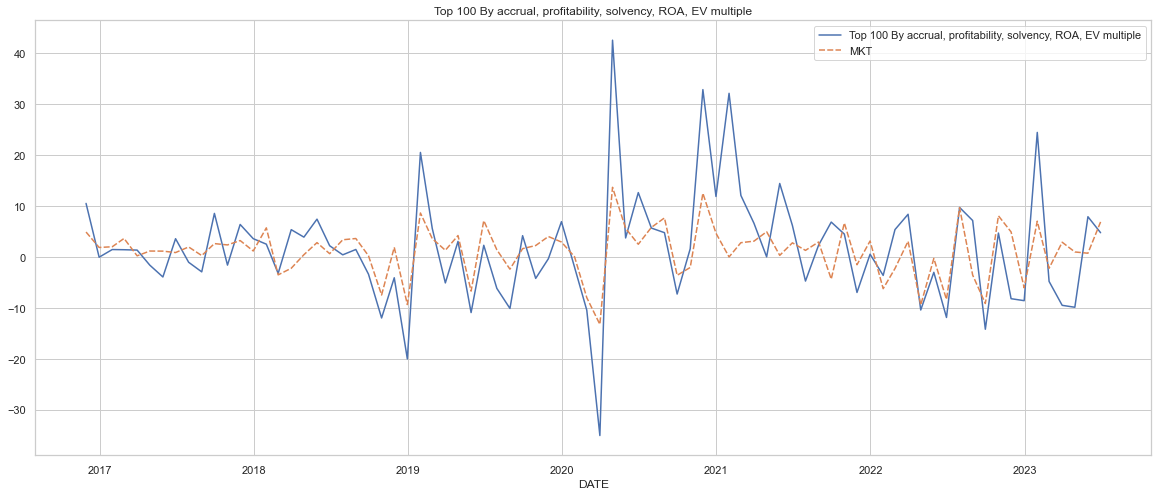

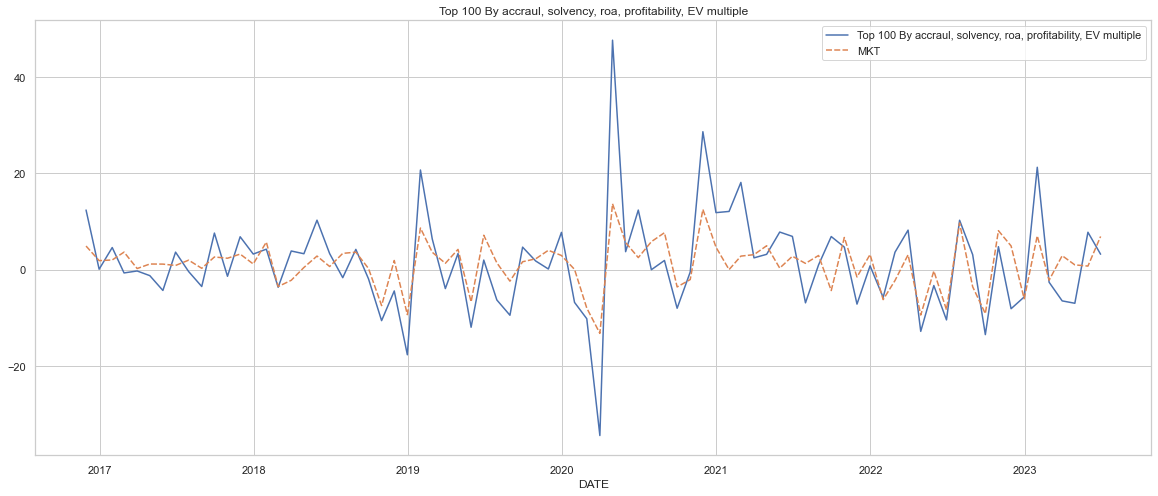

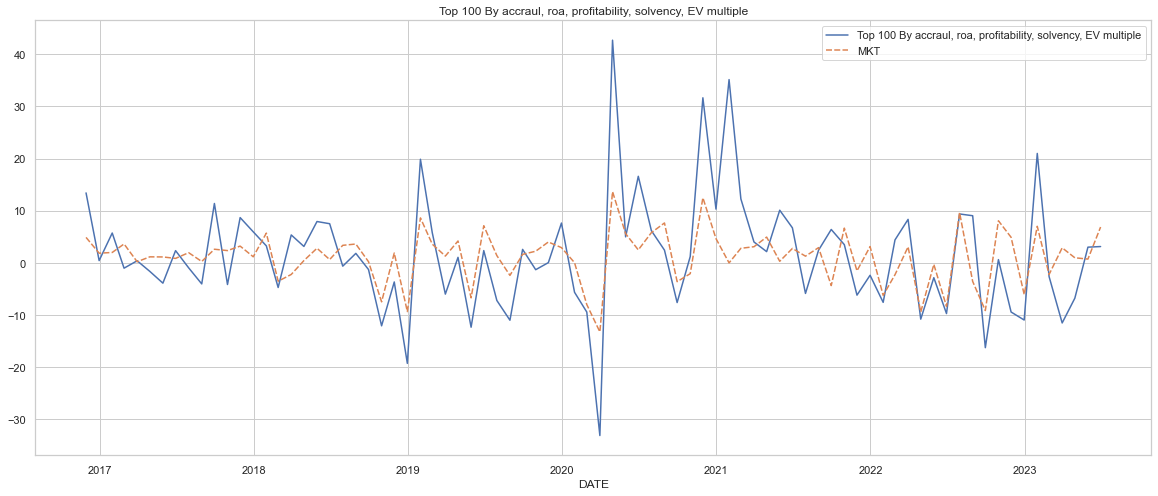

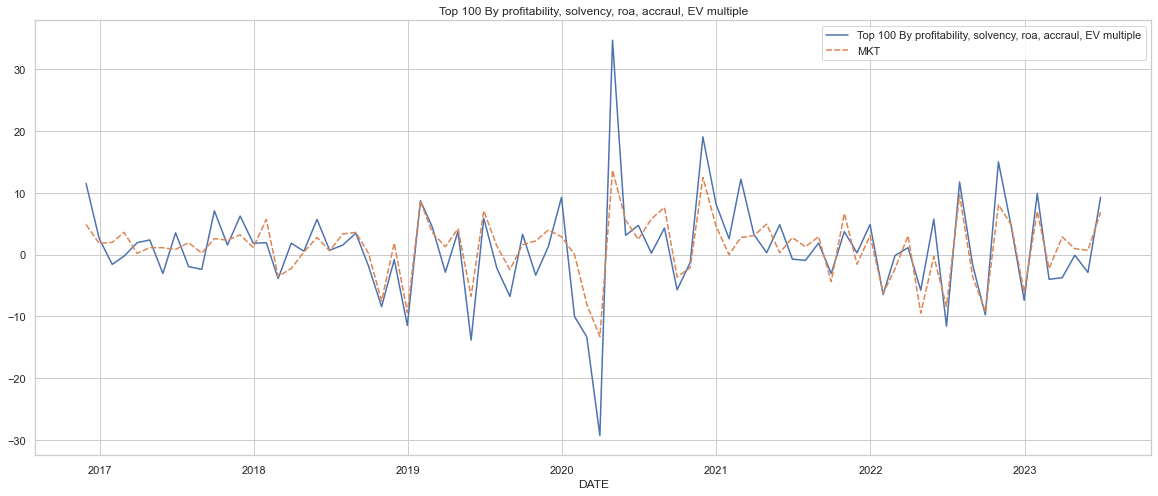

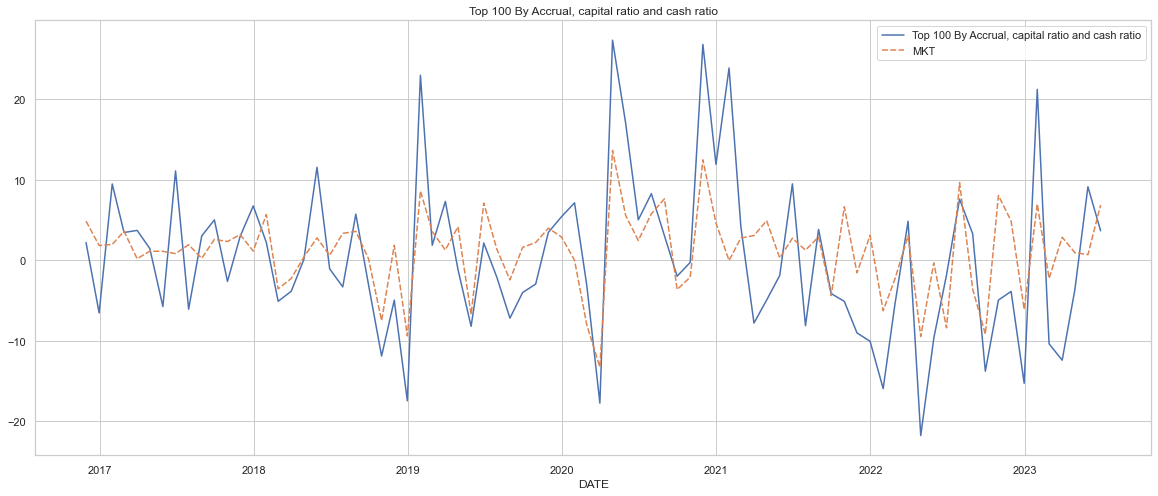

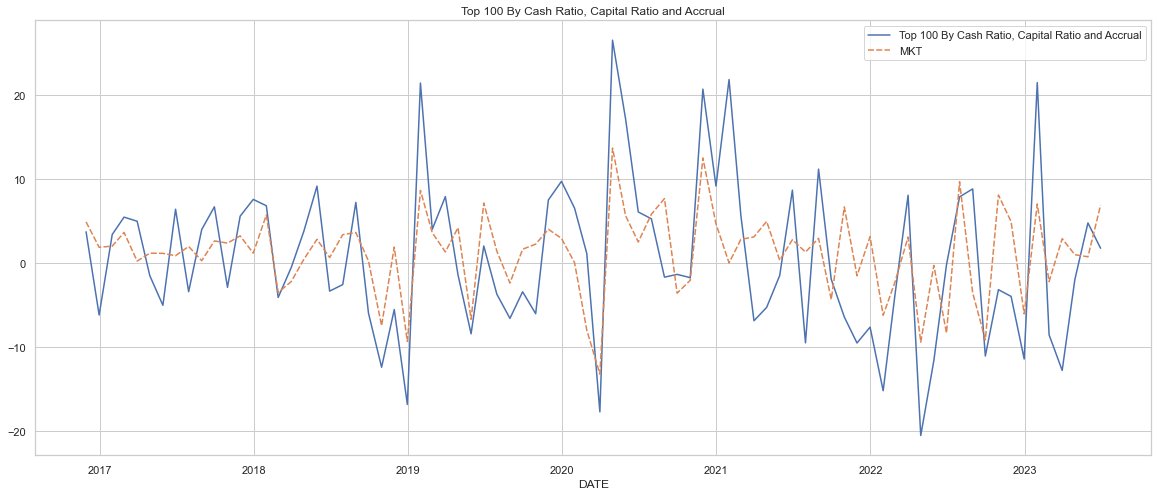

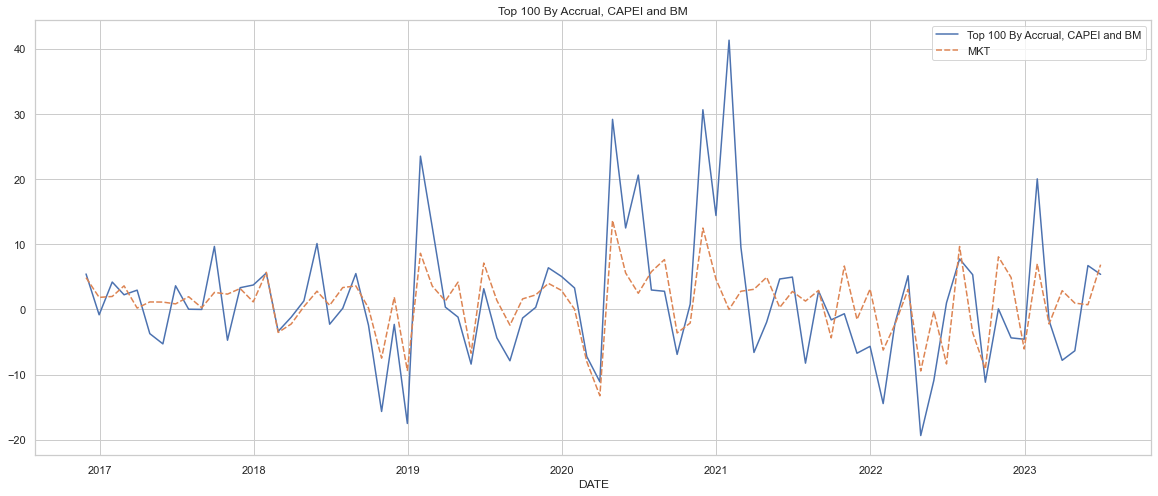

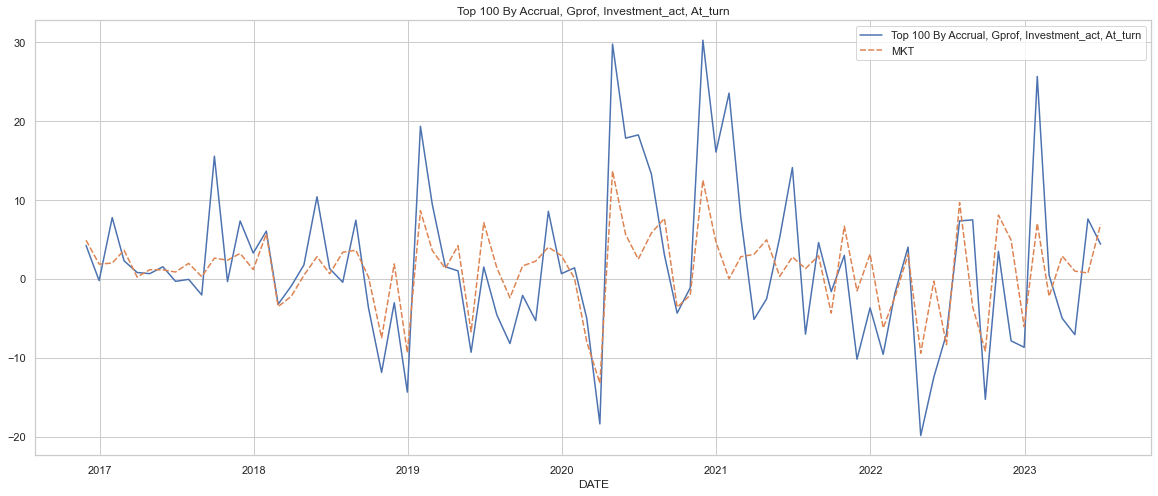

In [73]:
for i in range(len(returns)):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20,8))
    sns.lineplot(data = ret.iloc[-80:, [i, -2]] * 100)
    plt.title(returns.iloc[i, 0])
    plt.show()

<span style = "color:darkblue">

**Here we compare the multiple portfolios performance against the market reference return since 2010**

</span>

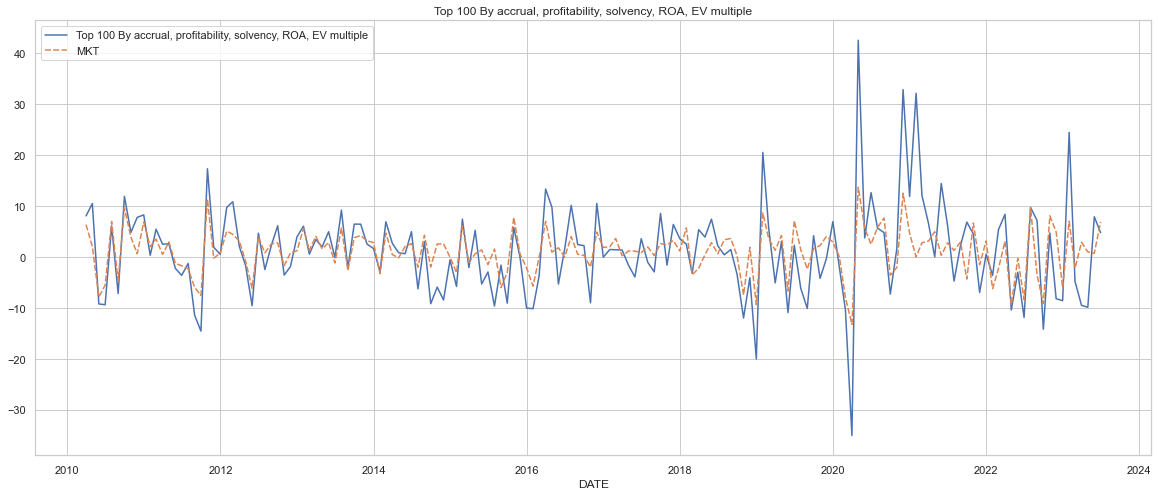

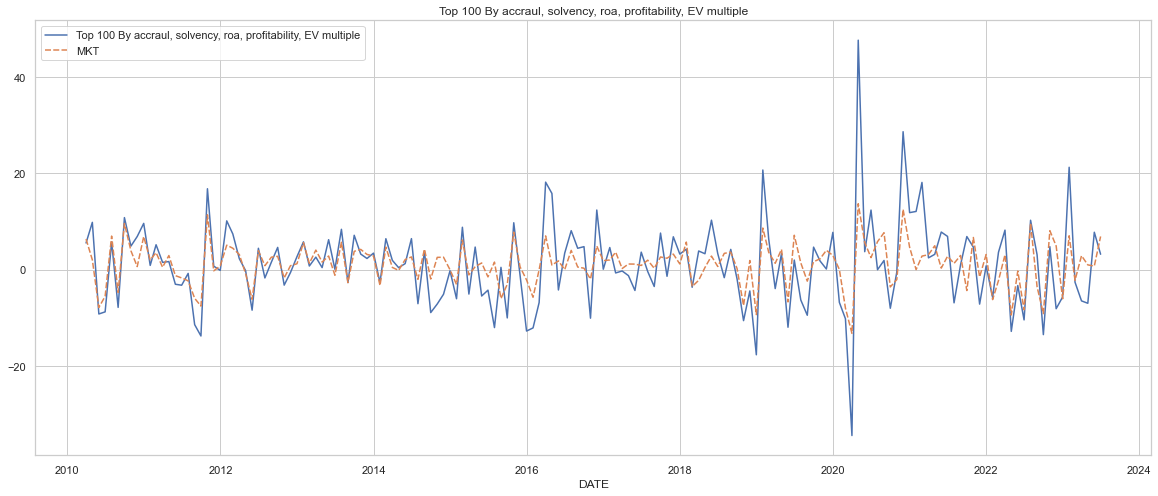

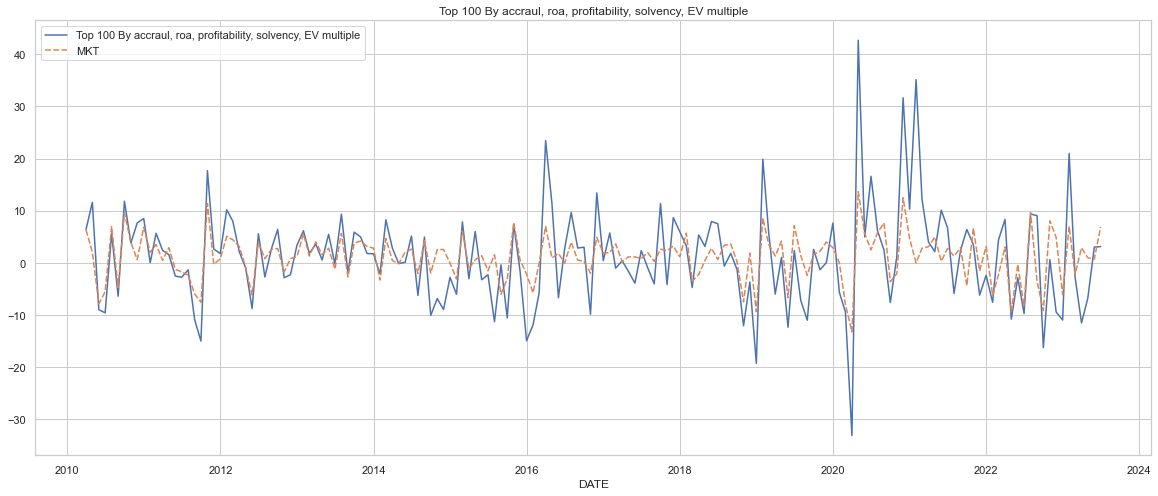

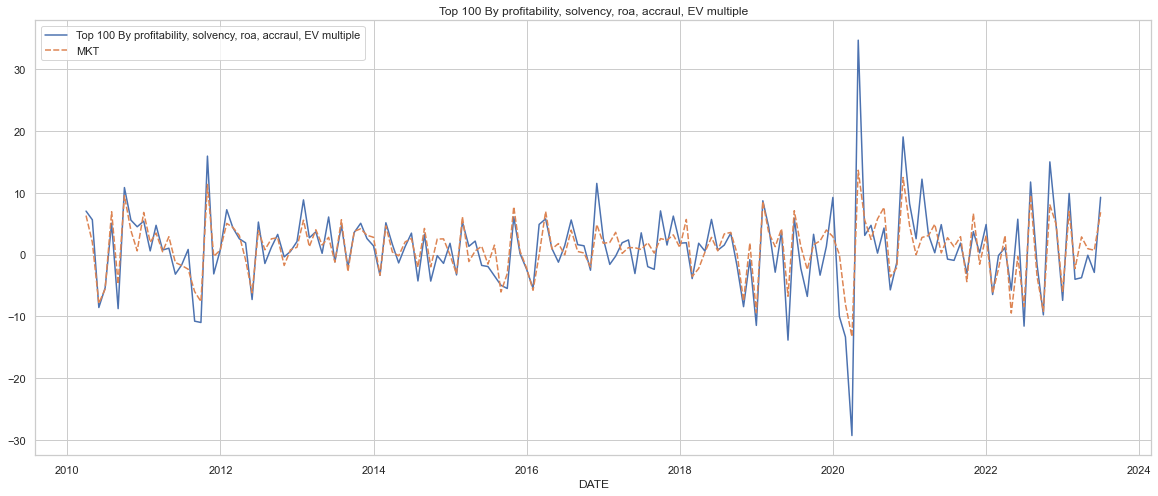

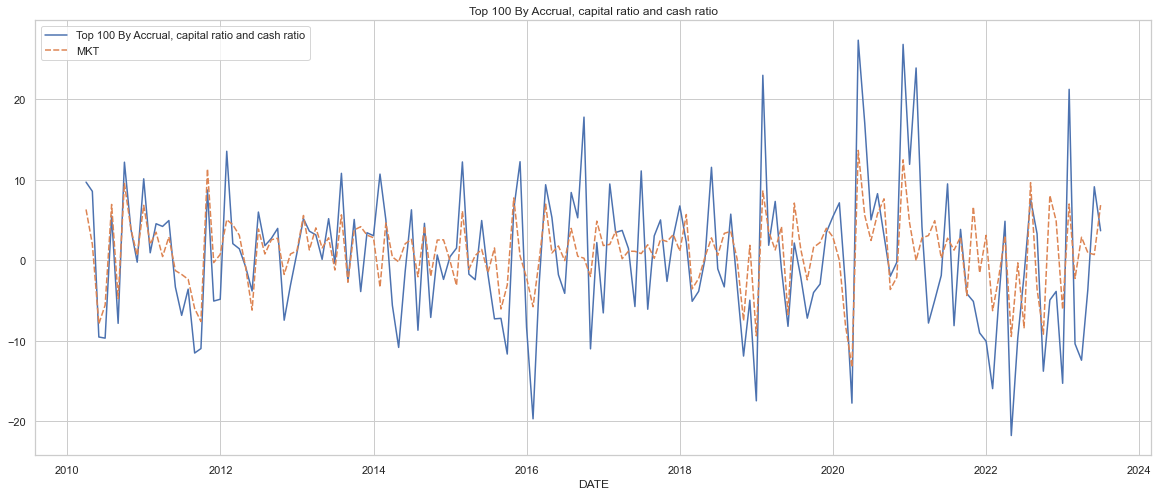

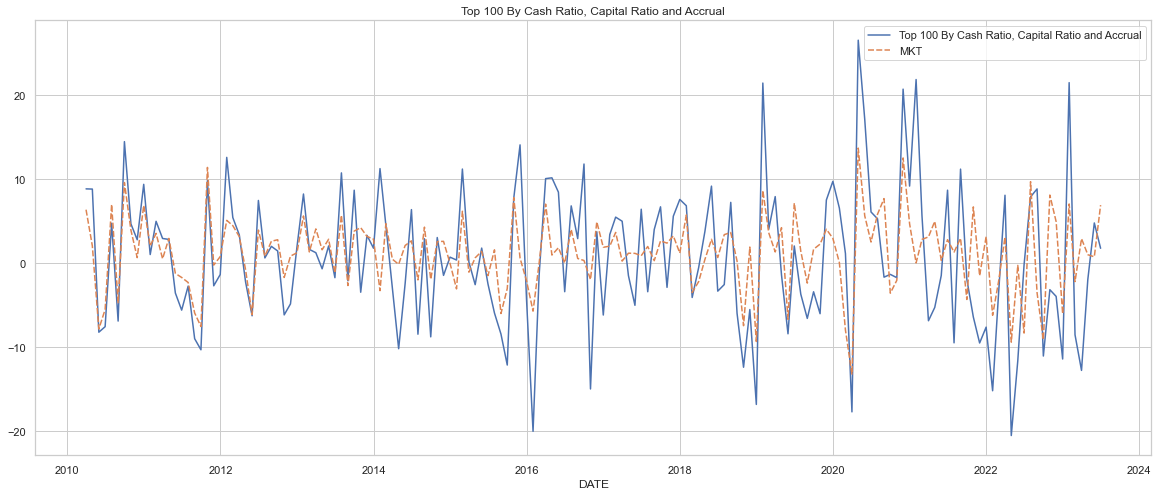

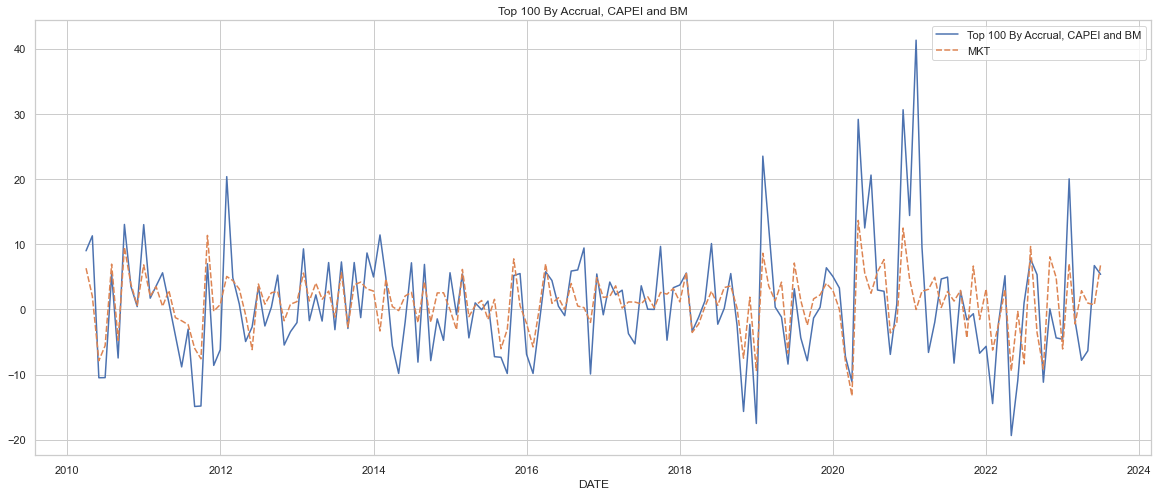

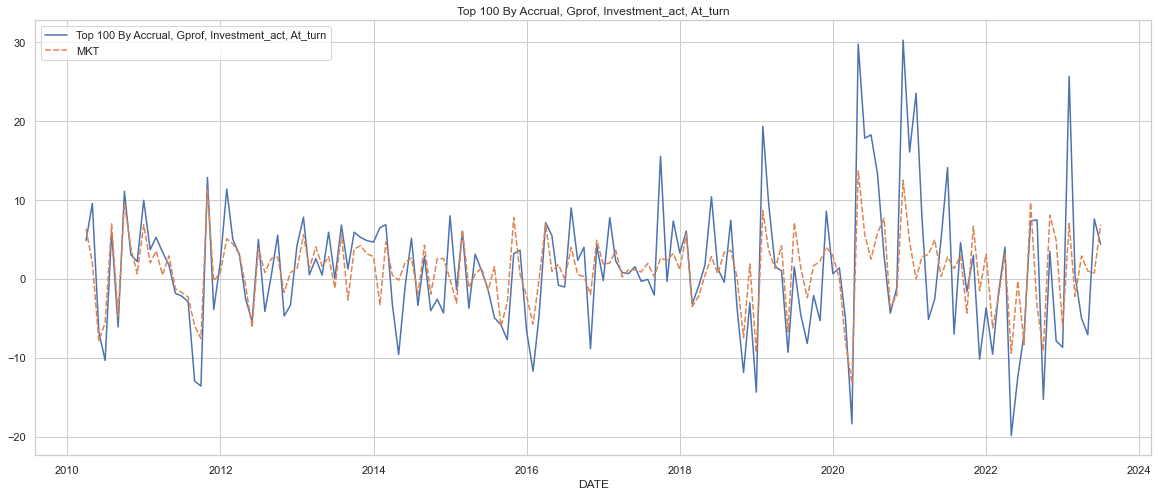

In [74]:
for i in range(len(returns)):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20,8))
    sns.lineplot(data = ret.iloc[-160:, [i, -2]] * 100)
    plt.title(returns.iloc[i, 0])
    plt.show()

# Portfolio Performance Analysis and Next Steps

Throughout our analysis, we experimented with various financial filters and portfolio strategies to identify configurations that optimize returns while managing risk. Here's a summary of the results and patterns observed across different portfolio compositions:

## Key Findings:

1. **Accrual, Profitability, Solvency, Return on Assets, Value**:
   - The Market Value Regression with Double Leverage Rank achieved an Alpha of 0.32, highlighting a return 0.32% higher than expected after risk adjustment. This combination resulted in 48% excess return and 65% volatility highlight high return with significantly higer risk.

2. **Accrual, Solvency, Return on Assets, Profitability, and Value**:
   - This scenario delivered an Alpha of 0.28 with a 44% excess return and 61% volatility, indicating a high return and high risk profile.
3. **Accrual, Capital Ratio, and Cash Ratio**:
   - Exhibiting an Alpha of 0.30, this combination offered a 44% excess return at a higher volatility of 69%. The Sharpe ratio of 0.64 suggests the high risk associated.

4. **Accrual, CapEI, and BM**:
   - Showcasing a high Alpha of 0.47, this set demonstrated superior risk-adjusted returns, with a 60% excess return and 67% volatility. 

5. **Accrual, Profitability, Investments, Value**:
   - Achieving an Alpha of 0.43, this filter combination presented a strong risk-adjusted performance, with a 58% excess return and 67% volatility. 

## Patterns Observed:
- **High Alpha and Sharpe Ratios**: Portfolios often exhibited high alpha values, indicating strong risk-adjusted performance above market expectations. High Sharpe ratios across certain combinations further signal their attractiveness for investment, balancing higher returns against the volatility or risk taken.
- **Volatility Considerations**: While some portfolios showed substantial excess returns, they were also associated with higher volatility levels, emphasizing the need for investors to weigh potential returns against the risk of larger drawdowns.

## Concluding Remarks:
This project was an exploratory experiment designed to unveil the potential of using detailed financial filters alongside application of Machine Learning to enhance investment returns. Our findings suggest promising avenues for portfolio optimization, with certain combinations of filters and strategies outperforming market benchmarks significantly.

## Potential Next Steps:

- **Rigorous Testing with Complex Machine Learning Methods**: Diving deeper into complex models and feature engineering could enhance the accuracy of return predictions, potentially boosting portfolio performance further.
- **Transaction Costs and Portfolio Rebalancing Analysis**: Understanding the impact of security turnover on transaction costs and exploring strategies to minimize these costs without sacrificing return potential would be crucial for practical implementation.

Our journey through this financial analysis landscape has revealed a rich tapestry of strategies and insights, laying the groundwork for future exploration and refinement in portfolio management.
